In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pickle as pkl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from tqdm import tqdm

from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.GraphClass import CausalGraph
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.SHD import SHD

import io
import matplotlib.image as mpimg

import seaborn as sns

In [5]:
#galtypes = ['ell','len','spr']
galtypes = ['ell_6var']
#typename = {'ell':'E','len':'S0','spr':'S','full':'Total'}
typename = {'ell_6var':'E_6var'}

# labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
#        r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']
# labels_list_fci = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']

labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$', r'$\text{M}^*$', r'$\text{sSFR}$']
labels_list_fci = ['M_bh','sigma_0', 'R_e','Sigma_e','M*', 'sSFR']

In [6]:
## from dag-gflownet
def expected_shd(posterior, ground_truth):
    """Compute the Expected Structural Hamming Distance.

    This function computes the Expected SHD between a posterior approximation
    given as a collection of samples from the posterior, and the ground-truth
    graph used in the original data generation process.

    Parameters
    ----------
    posterior : np.ndarray instance
        Posterior approximation. The array must have size `(B, N, N)`, where `B`
        is the number of sample graphs from the posterior approximation, and `N`
        is the number of variables in the graphs.

    ground_truth : np.ndarray instance
        Adjacency matrix of the ground-truth graph. The array must have size
        `(N, N)`, where `N` is the number of variables in the graph.

    Returns
    -------
    e_shd : float
        The Expected SHD.
    """
    # Compute the pairwise differences
    diff = np.abs(posterior - np.expand_dims(ground_truth, axis=0))
    diff = diff + diff.transpose((0, 2, 1))

    # Ignore double edges
    diff = np.minimum(diff, 1)
    shds = np.sum(diff, axis=(1, 2)) / 2

    #return np.mean(shds)
    return shds


def plot_top_dags(dags, p, num=10, labels_list=labels_list, render_latex=False, save: str |None = None):
    # Render LaTeX to an image
    def render_latex_to_file(str, filepath):
        fig = plt.figure()
        fig = plt.figure(figsize=(0.01, 0.01))
        fig.text(0.5, 0.5, str, fontsize='xx-large', ha='center', va='center')
        plt.axis('off')
        plt.savefig(filepath, bbox_inches='tight')
        plt.close(fig)
    
    if render_latex:
        for i,string in enumerate(labels_list):
            render_latex_to_file(string,'plots/label'+str(i)+'.png')

    for i, sample in enumerate(dags[:num]):
        graph = nx.from_numpy_array(sample, create_using=nx.DiGraph)

        
        # Apply labels to the graph
        for j,node in enumerate(graph.nodes()):
            graph.nodes[node]['image'] = 'plots/label'+str(j)+'.png'
            graph.nodes[node]['label'] = ''

        
        gviz = nx.nx_agraph.to_agraph(graph)

        gviz.graph_attr['label'] = format(p[i]*100,'.3g')+'%'
        gviz.graph_attr['labelloc'] = 't'  # Top of the graph
        gviz.graph_attr['labeljust'] = 'l'  # Right-justified
        gviz.graph_attr['fontsize'] = 15
        gviz.graph_attr['fontname'] = 'Calibri'
        gviz.graph_attr['dpi'] = 100


        # Render the graph to a PNG image and display it inline
        if save is None:
            output_path = 'plots/graph.png'
        else:
            output_path = 'plots/'+save+'_top'+str(i+1)+'.png'
        gviz.draw(output_path, prog='dot', format='png')  # Use 'dot' or another Graphviz layout engine

        

        #print(counts[i],'/',samplesize,'(',counts[i]/samplesize*100,'%)')
        # Display the image
        display(Image(output_path))


def marginal_matrix(dags, p, labels_list=labels_list,typename: str |None = None,plot_path=False):
    # edge marginals
    confusion = np.average(dags, axis=0, weights=p)

    #sns.heatmap(confusion, cmap='gray', annot=confusion,fmt='.3f')
    sns.heatmap(confusion, cmap='gray', annot=confusion)
    if typename is not None:
        plt.title(typename)
    plt.xlabel('Child')
    plt.ylabel('Parent')
    plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    plt.show()

    # path marginals
    if plot_path:
        transitive_closure = np.zeros(dags.shape)
        for i in range(dags.shape[0]):
            # get transitive closure of the graph
            G = nx.from_numpy_array(dags[i], create_using=nx.DiGraph)
            # Compute the transitive closure of the graph
            TC = nx.transitive_closure(G)

            # Convert the transitive closure graph back to a numpy array
            tc_adj_matrix = nx.to_numpy_array(TC, dtype=int)

            transitive_closure[i] = tc_adj_matrix
        
        confusion = np.average(transitive_closure, axis=0, weights=p)
        sns.heatmap(confusion, cmap='gray', annot=confusion)
        if typename is not None:
            plt.title(typename)
        plt.xlabel('Descendant')
        plt.ylabel('Ancestor')
        plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
        plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
        plt.show()

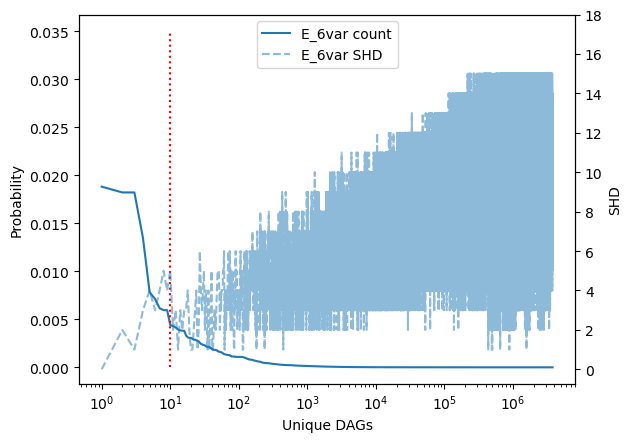

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p={}
shds={}
order={}
for galtype in galtypes:
    folder = 'exact_posteriors'
    # load bge scores
    bge = np.load(folder+'/bge_'+galtype+'.npy')
    # turn scores into probabilities, and normalize
    bge = np.exp(bge)
    p[galtype] = bge/np.sum(bge)

    # sort probabilities
    order[galtype] = np.argsort(-p[galtype])
    p[galtype] = p[galtype][order[galtype]]

    # calculate shds
    dags = np.load(folder+'/dags_'+galtype+'.npy')
    dags = dags[order[galtype]]
    shds[galtype] = expected_shd(dags, dags[0])

    # plot count of unique samples on using the left y axis, and the shd on the right y axis
    ax1.plot(np.arange(len(p[galtype]))+1, p[galtype],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(p[galtype]))+1, shds[galtype], alpha=0.5,ls='--',label=typename[galtype]+' SHD')


ax1.set_xlabel('Unique DAGs')
ax1.set_ylabel('Probability')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 20, 2))
ax1.vlines(10,0,0.035,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')




E_6var


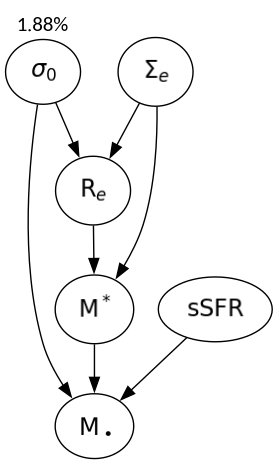

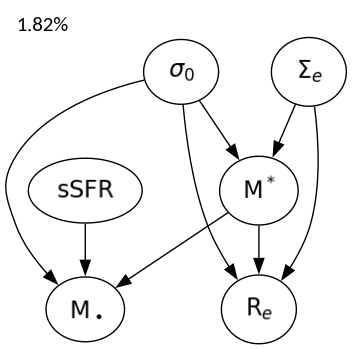

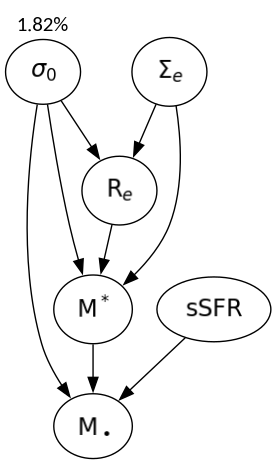

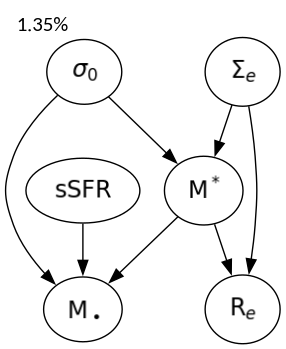

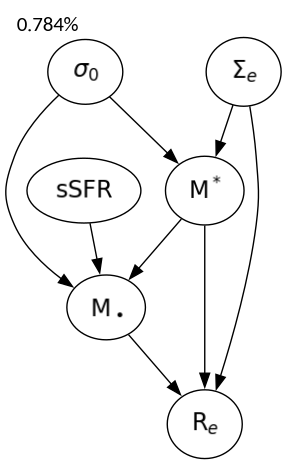

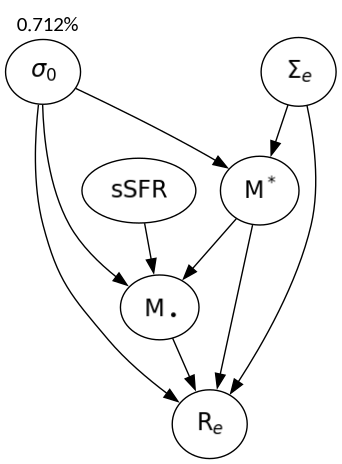

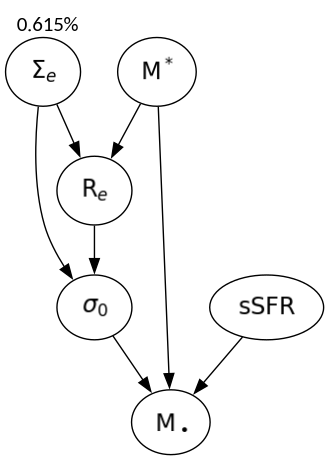

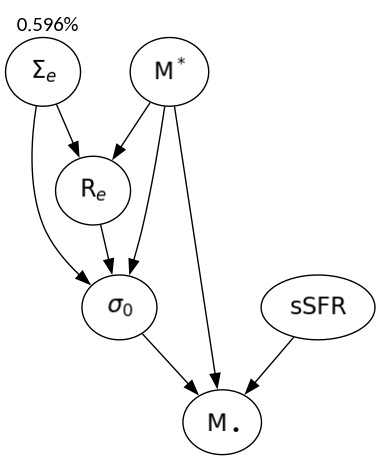

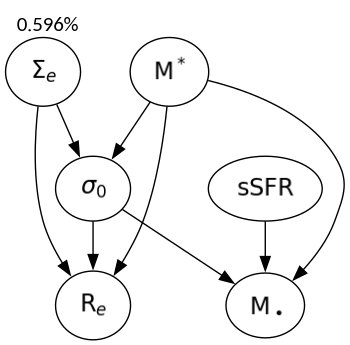

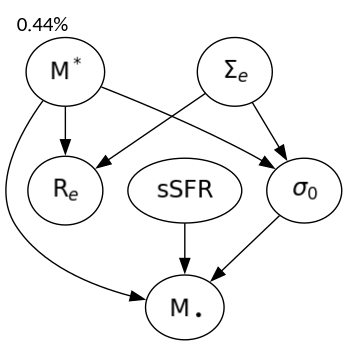

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

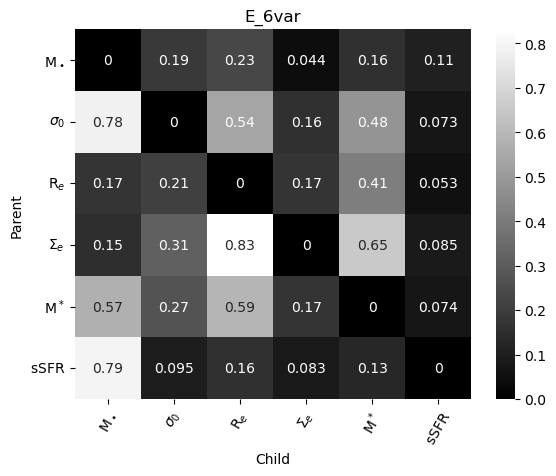

In [8]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    folder = 'exact_posteriors'
    dags = np.load(folder+'/dags_'+galtype+'.npy')
    dags = dags[order[galtype]]
    plot_top_dags(dags, p[galtype], num=10, save=None, render_latex=True)
    marginal_matrix(dags, p[galtype], typename=typename[galtype],plot_path=False)
    print('===================================================')

In [9]:
from math import comb


def exact_posterior_progress(total,now):
    sum_total = 0
    sum_now = 0
    for i in range(total):
        sum_total+=comb(total,i)

    for i in range(now):
        sum_now+=comb(total,i)

    print('Progress:',sum_now/sum_total*100,'%')
    return None

In [11]:
exact_posterior_progress(43,10)

Progress: 0.008507758730048467 %
